**Quick draw Recogniztion**

# AI Spring 2022 Final Project 

### Examples:
>https://www.kaggle.com/code/kotarojp/first-step-for-submission-keras-resnet50/notebook

>https://www.kaggle.com/code/gaborfodor/greyscale-mobilenet-lb-0-892






# 1. Install modules and helper functions


In [6]:
#!pip install tensorflow
import tensorflow as tf
print('Using tensorflow version: ', tf.__version__)

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import ast
import random
import cv2
import matplotlib.pyplot as plt
import gc
import json
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Using tensorflow version:  2.9.1


In [7]:
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

Metal device set to: Apple M1 Pro
Found GPU at: /device:GPU:0


2022-06-07 22:13:06.854437: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-07 22:13:06.854772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 2. Preprocess Data

- Saved train_simplified directory in Google Drive.
- Total 340 classes of picture, each with at least 120 thousands data.
- To avoid long time training, we may choose only a part of them.

In [12]:
dir = os.path.join(os.getcwd(), 'train_simplified')

csv_paths = []
labels = []
count = 0
for file in os.listdir(dir):
  csv_paths.append(os.path.join(dir, file))
  labels.append(file.split('.')[0])
 

# 3. Build Model 
- MobileNet

### Hyperparameters

In [13]:
BATCH_SIZE = 340
EPOCHS = 30
BASE_IMG_SIZE = 256
IMG_SIZE = 128

STEP_PER_EPOCH = 300

NUM_CLASS = 340
IMAGE_PER_CLASS = 10


### Create Model

In [14]:
def top_3_accuracy(y_true, y_pred):
  return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_1_accuracy(y_true, y_pred):
  return top_k_categorical_accuracy(y_true, y_pred, k=1)

In [15]:
model = MobileNet(input_shape=(IMG_SIZE, IMG_SIZE, 1), alpha=1, weights=None, classes=NUM_CLASS)
model.compile(optimizer=Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=[categorical_crossentropy, top_3_accuracy, top_1_accuracy])


2022-06-07 22:16:09.577748: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-07 22:16:09.577774: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Show Model Structure

In [8]:
# print(model.summary())

# 4. Create One Hot Encoder

In [16]:
wordEncoder = LabelEncoder()
wordEncoder.fit(labels)

def oneHotEncoder(word):
  return to_categorical(wordEncoder.transform([word]), num_classes=NUM_CLASS).reshape((NUM_CLASS,1)) #ugly

# test_y = oneHotEncoder('The Eiffel Tower')
# print(test_y)
# b = [5]
# print(to_categorical(b, 6).reshape(6))
# print(wordEncoder.transform(['arm', 'asparagus', 'axe']))

# 5. Create Train Data Generator

In [17]:
def draw_image_cv2(strokes, img_size, thickness=6, time_color=True):
  img = np.zeros((BASE_IMG_SIZE, BASE_IMG_SIZE), np.uint8)
  for t, stroke in enumerate(strokes):
    for i in range(len(stroke[0])-1):
      color = 255 - min(t, 10) * 13 if time_color else 255
      _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i+1], stroke[1][i+1]),color, thickness)
  
  if img_size != BASE_IMG_SIZE:
    return cv2.resize(img, (img_size, img_size))
  else: 
    return img

def trainingdata_generator(batch_size, img_size, num_class, thickness=6, time_color=True):
  while True:
    x = np.zeros((batch_size, img_size, img_size, 1))
    y = np.zeros((batch_size, NUM_CLASS, 1))
    for i in range(batch_size//IMAGE_PER_CLASS):
      df = pd.read_csv(random.choice(csv_paths), nrows = IMAGE_PER_CLASS, skiprows=[j for j in range(1,i*IMAGE_PER_CLASS)])
      df['drawing'] = df['drawing'].apply(json.loads)
      for k, raw_strokes in enumerate(df['drawing']):
        x[i*IMAGE_PER_CLASS+k, :, :, 0] = draw_image_cv2(raw_strokes, img_size)

      y[i*IMAGE_PER_CLASS: (i+1)*IMAGE_PER_CLASS, :,:] = oneHotEncoder(df['word'][0])
    x = preprocess_input(x).astype(np.float32)
    yield x, y
      
def df_to_images(df, img_size, thickness=6, time_color=True):
  x = np.zeros((len(df), img_size, img_size, 1))
  df['drawing'] = df['drawing'].apply(json.loads)
  for i , raw_strokes in enumerate(df['drawing']):
    x[i, :, :, 0] = draw_image_cv2(raw_strokes, img_size = img_size)
  # for k, raw_strokes in enumerate(df['drawing']):
  #       print(type(raw_strokes))
  #       raw_strokes = json.loads(raw_strokes)
  #       print(type(raw_strokes))
  #       x[i*IMAGE_PER_CLASS+k, :, :, 0] = draw_image_cv2(raw_strokes, img_size)
  x = preprocess_input(x).astype(np.float32)
  return x


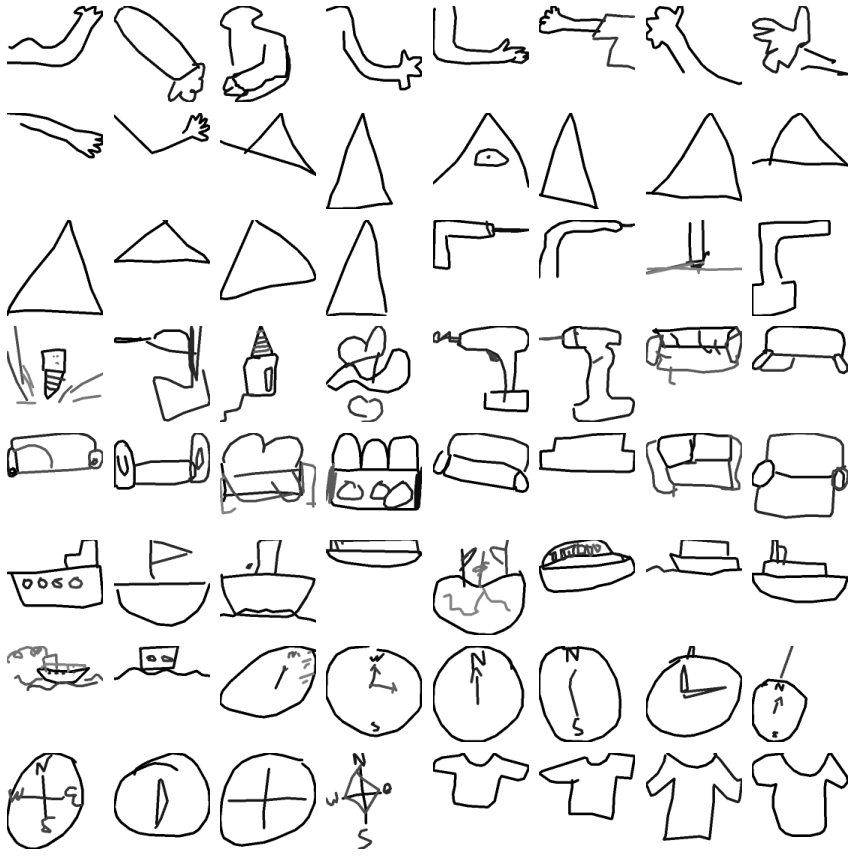

In [18]:
NUM_CSVS = 340

train_datagen = trainingdata_generator(batch_size = BATCH_SIZE, img_size = IMG_SIZE, num_class=340)

x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();


# 6. Create Validation Data

In [19]:
VAL_IMG_PER_CLASS = 10

In [20]:
def create_validation_set(csv_paths, class_num, image_per_class, img_size, thickness=6):
  
  x = np.zeros((class_num*image_per_class, img_size, img_size, 1))
  y = np.zeros((class_num*image_per_class, NUM_CLASS, 1))
  for k in range(class_num-1):
    df = pd.read_csv(csv_paths[k],nrows=image_per_class, header=0, skiprows=[i for i in range(1, 50000+k*image_per_class)]) 
    x[k*image_per_class:(k+1)*image_per_class] = df_to_images(df, img_size)
    y[k*image_per_class:(k+1)*image_per_class] = oneHotEncoder(df["word"][0])
    del(df)
    gc.collect()
  return x, y

In [21]:
x_valid, y_valid = create_validation_set(csv_paths, NUM_CLASS, IMAGE_PER_CLASS, IMG_SIZE)
print(x_valid.shape, y_valid.shape)


(3400, 128, 128, 1) (3400, 340, 1)


# 7. Training

In [22]:
callbacks = [
             ReduceLROnPlateau(monitor="val_top_3_accuracy", factor = 0.5, patience = 3, mode='max', min_lr=1e-5, verbose=1),
             ModelCheckpoint('model.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True,
                    save_weights_only=True),
]

In [ ]:
histories = []
history = model.fit(train_datagen, epochs = EPOCHS, steps_per_epoch=STEP_PER_EPOCH, verbose=1, validation_data=(x_valid, y_valid), callbacks=callbacks)
histories.append(history)
print(histories)

Epoch 1/30


2022-06-07 22:18:51.341672: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-07 22:18:52.430504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - ETA: 0s - loss: 5.0979 - categorical_crossentropy: 5.0979 - top_3_accuracy: 0.1150 - top_1_accuracy: 0.0512

2022-06-07 22:21:39.379516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - 171s 541ms/step - loss: 5.0979 - categorical_crossentropy: 5.0979 - top_3_accuracy: 0.1150 - top_1_accuracy: 0.0512 - val_loss: 6.4263 - val_categorical_crossentropy: 6.4263 - val_top_3_accuracy: 0.0088 - val_top_1_accuracy: 0.0029 - lr: 0.0020
Epoch 2/30
300/300 [==============================] - 162s 541ms/step - loss: 3.3989 - categorical_crossentropy: 3.3989 - top_3_accuracy: 0.4207 - top_1_accuracy: 0.2349 - val_loss: 4.8418 - val_categorical_crossentropy: 4.8418 - val_top_3_accuracy: 0.2026 - val_top_1_accuracy: 0.0950 - lr: 0.0020
Epoch 3/30
300/300 [==============================] - 163s 542ms/step - loss: 2.5976 - categorical_crossentropy: 2.5976 - top_3_accuracy: 0.6035 - top_1_accuracy: 0.3848 - val_loss: 3.0219 - val_categorical_crossentropy: 3.0219 - val_top_3_accuracy: 0.5335 - val_top_1_accuracy: 0.3318 - lr: 0.0020
Epoch 4/30
300/300 [==============================] - 164s 547ms/step - loss: 2.1523 - categorical_crossentropy: 2

# 8. Learning Curve

In [ ]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in histories], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();


# 9. Generate Prediction